In [150]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [151]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable_1:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu_16:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_17:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool_5:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_18:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_19:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_6:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_20:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_21:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_22:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_23:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_7:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_24:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


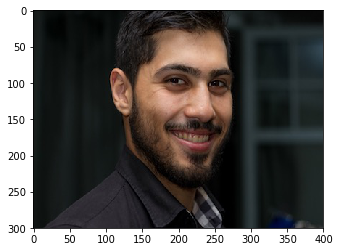

In [163]:
content_image = scipy.misc.imread("images/eren1.jpg")
imshow(content_image)

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=(n_H*n_W, n_C))
    a_G_unrolled = tf.reshape(a_G, shape=(n_H*n_W, n_C))
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)) / (4 * n_H * n_W * n_C))
    
    return J_content

In [6]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.765593


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


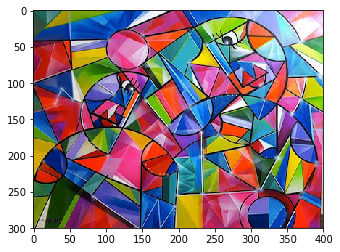

In [165]:
style_image = scipy.misc.imread("images/jraynaud.jpg")
imshow(style_image)

This painting was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

Lets see how you can now define a "style" const function $J_{style}(S,G)$. 

In [8]:
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [9]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


In [10]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S, shape=(n_H*n_W, n_C))
    a_G = tf.reshape(a_G, shape=(n_H*n_W, n_C))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG)) / (4 * (n_C * n_C) * (n_H * n_W) * (n_H * n_W)))
    
    return J_style_layer

In [11]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.190277


In [12]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [13]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = np.multiply(alpha, J_content) + np.multiply(beta, J_style)
    
    return J

In [15]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [16]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [210]:
content_image = scipy.misc.imread("images/eren4.jpg")
content_image = reshape_and_normalize_image(content_image)
print (content_image.shape)

(1, 300, 400, 3)


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [211]:
style_image = scipy.misc.imread("images/jraynaud3.jpg")
style_image = reshape_and_normalize_image(style_image)
print (style_image.shape)

(1, 300, 400, 3)


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


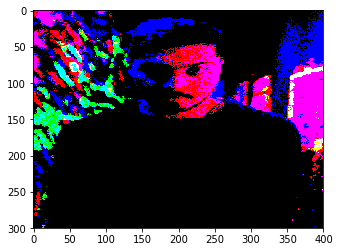

In [212]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [213]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [214]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [215]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [216]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [217]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [218]:
def model_nn(sess, input_image, num_iterations = 600):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    generated_image = sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [219]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 235304270000.0
content cost = 14745.67
style cost = 5882603000.0
Iteration 20 :
total cost = 74889330000.0
content cost = 40617.66
style cost = 1872223100.0
Iteration 40 :
total cost = 17454297000.0
content cost = 54574.703
style cost = 436343800.0
Iteration 60 :
total cost = 9564154000.0
content cost = 55032.94
style cost = 239090100.0
Iteration 80 :
total cost = 6837878300.0
content cost = 56982.4
style cost = 170932700.0
Iteration 100 :
total cost = 5494735400.0
content cost = 57852.16
style cost = 137353920.0
Iteration 120 :
total cost = 4655442000.0
content cost = 58525.688
style cost = 116371416.0
Iteration 140 :
total cost = 4054406000.0
content cost = 59089.48
style cost = 101345380.0
Iteration 160 :
total cost = 3589266700.0
content cost = 59579.13
style cost = 89716776.0
Iteration 180 :
total cost = 3214687700.0
content cost = 60032.426
style cost = 80352184.0
Iteration 200 :
total cost = 2906002200.0
content cost = 60456.24
style cost = 72634936.0


array([[[[ -22.803572 ,  -76.65033  ,  -24.975262 ],
         [ -19.957018 ,  -64.4257   ,   -5.671547 ],
         [ -33.055786 ,  -74.59534  ,  -28.870192 ],
         ...,
         [ -58.815575 , -142.6967   ,  -16.533045 ],
         [ -42.912598 ,  -94.41796  ,  -24.50007  ],
         [ -14.06545  ,    8.21994  ,   38.556946 ]],

        [[ -32.579556 ,  -63.81629  ,  -35.6553   ],
         [  -4.1054897,  -50.48466  ,   -2.8462825],
         [  -9.537453 ,  -58.538525 ,  -19.38107  ],
         ...,
         [-137.37178  ,  -66.36848  ,   19.96999  ],
         [-102.07157  ,  -65.392    ,   -6.1097994],
         [   3.1069527,   21.630571 ,  112.968796 ]],

        [[  42.543373 ,   -6.9544487,   62.923775 ],
         [  37.790104 ,   13.439742 ,   39.3527   ],
         [  51.95204  ,   57.474308 ,   90.03361  ],
         ...,
         [-206.29724  ,  -47.80723  ,  103.06032  ],
         [ -92.88611  ,  -54.18522  ,   43.04535  ],
         [  98.12315  ,   11.673676 ,  228.30638  ]],

/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


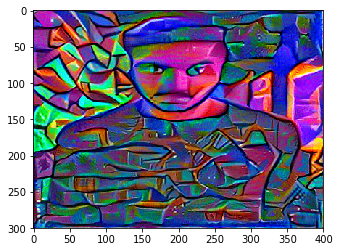

In [220]:
imshow(scipy.misc.imread("output/580.png"))

In [198]:
# from PIL import Image 
# image_file = Image.open("images/vienna.jpg") # open colour image
# image_file = image_file.convert('L') # convert image to black and white
# bw = image_file.point(lambda x: 0 if x<128 else 255, '1')
# bw.save("images/vienna2.jpg")

In [88]:
# imshow(scipy.misc.imread("images/vienna2.jpg"))